In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten,SimpleRNN
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score

In [2]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('..\largedata')

# Actions that we try to detect  actions = np.array(['Familja', 'Missier', 'Bieb'])
actions = np.array(['Kont', 'Dar', 'Flus', 'Missier', 'Passaport','Jekk','Widnejn','Issib','Ħalq','Tiegħi'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

label_map = {label:num for num, label in enumerate(actions)}

label_map # When this is added accuracy skyrockets IMP

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape
np.array(labels).shape
X = np.array(sequences)
X.shape
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test.shape

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [3]:
X = np.array(sequences)
y = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [5]:
input_shape = (30, 1662)
num_classes = len(actions)

model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=50, callbacks=[TensorBoard(log_dir='Logs')])

Epoch 1/50
8/8 [==============================] - 4s 14ms/step - loss: 2.8328 - categorical_accuracy: 0.1000
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 2.2171 - categorical_accuracy: 0.1792
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 1.9608 - categorical_accuracy: 0.3375
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 1.8048 - categorical_accuracy: 0.3792
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 1.5535 - categorical_accuracy: 0.4208
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 1.3251 - categorical_accuracy: 0.5042
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0632 - categorical_accuracy: 0.6792
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.9355 - categorical_accuracy: 0.6833
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8055 - categorical_accuracy: 0.7000
Epoch 10/50
8/8 [==========

In [6]:
yhat = np.argmax(model.predict(X_test), axis=1)
ytrue = np.argmax(y_test, axis=1)
print(classification_report(ytrue, yhat, target_names=actions, zero_division=0))
print("Confusion Matrix")
print(multilabel_confusion_matrix(ytrue, yhat))
print("Accuracy")
print(accuracy_score(ytrue, yhat))

2/2 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

        Kont       1.00      0.75      0.86         4
         Dar       1.00      0.78      0.88         9
        Flus       1.00      1.00      1.00         5
     Missier       0.80      1.00      0.89         8
   Passaport       1.00      1.00      1.00         6
        Jekk       0.75      1.00      0.86         3
     Widnejn       1.00      1.00      1.00         7
       Issib       1.00      1.00      1.00         8
        Ħalq       1.00      1.00      1.00         7
      Tiegħi       1.00      1.00      1.00         3

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60

Confusion Matrix
[[[56  0]
  [ 1  3]]

 [[51  0]
  [ 2  7]]

 [[55  0]
  [ 0  5]]

 [[50  2]
  [ 0  8]]

 [[54  0]
  [ 0  6]]

 [[56  1]
  [ 0  3]]

 [[53  0]
  [ 0  7]]

 [[52  0]
  [ 0  8

2/2 [==============================] - 0s 4ms/step


<Figure size 900x600 with 0 Axes>

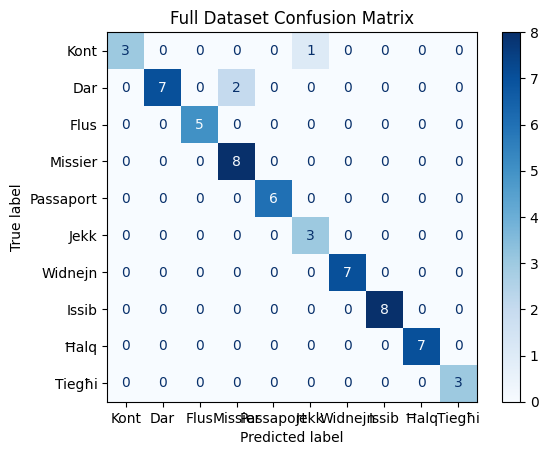

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9, 6))
ConfusionMatrixDisplay(cm, display_labels=actions).plot(cmap='Blues')
plt.title('Full Dataset Confusion Matrix')
plt.show()


In [8]:
model.save('model1.h5')